In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, feature
from skimage import data, transform

# Homework 3: A Simple face detector

We are going to build a simple facial detection algorithm

Instead of using pixel intensities as features (as you did in Homework 1), we'll use the HOG (Histrogram of Oriented Gradients) features.
HOG features focus on the structure or the shape of an object, and they are widely used in computer vision tasks for object detection.

Wikipedia has a reasonably good entry on HOG: https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

Text(0.5, 1.0, 'visualization of HOG features')

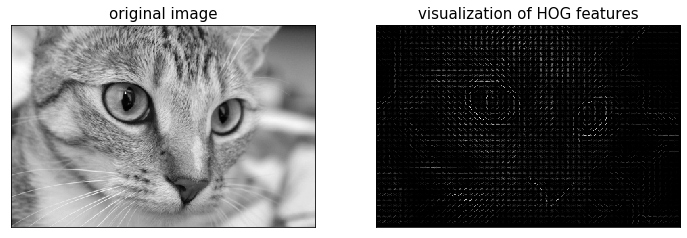

In [12]:
'visualization of HOG features'

image = color.rgb2gray(data.chelsea()) #load an image
hog_vec, hog_vis = feature.hog(image,visualize=True) #extract HOG features

'plot image and hog features'
fig, ax = plt.subplots(1,2, figsize = (12,6),
                       subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(image,cmap='gray')
ax[0].set_title('original image',fontsize=15)

ax[1].imshow(hog_vis,cmap = 'gray')
ax[1].set_title('visualization of HOG features',fontsize=15)

To build our face detector, we need

1. A set of face images

2. A set of nonface images

3. To extract the HOG features from all the images

## A set of face images:

In [13]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people() #load the labeled faces in the wild dataset
positive_patches = faces.images

positive_patches.shape

(8211, 62, 47)

The positive_patches dataset contains 8211 images, and each image has 2914 (62x47) features. 
Each feature simply represents one pixel's intensity.

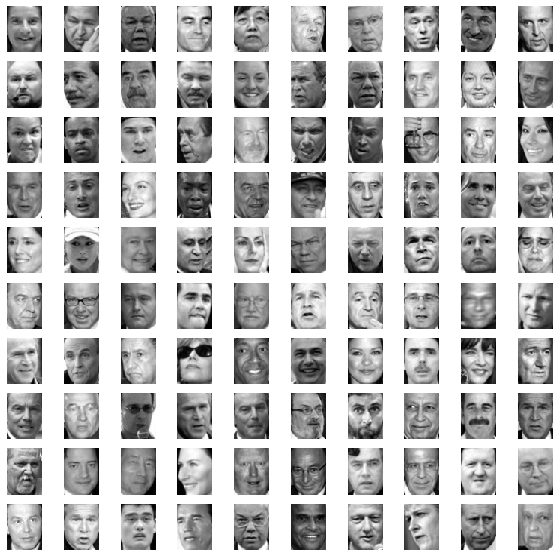

In [14]:
'display the first 100 faces'
plt.figure(figsize=(10,10))
for i in range(100):
    face_image = positive_patches[i]
    plt.subplot(10,10,i+1)
    plt.imshow(face_image,cmap = 'gray')
    plt.axis('off')

This gives us a sample of 8211 face images

## A negative training samples

In [7]:
imgs_to_use = ['camera','text','coins','moon','page','clock','immunohistochemistry','chelsea','coffee','hubble_deep_field']
images = [color.rgb2gray(getattr(data,name)()) for name in imgs_to_use]

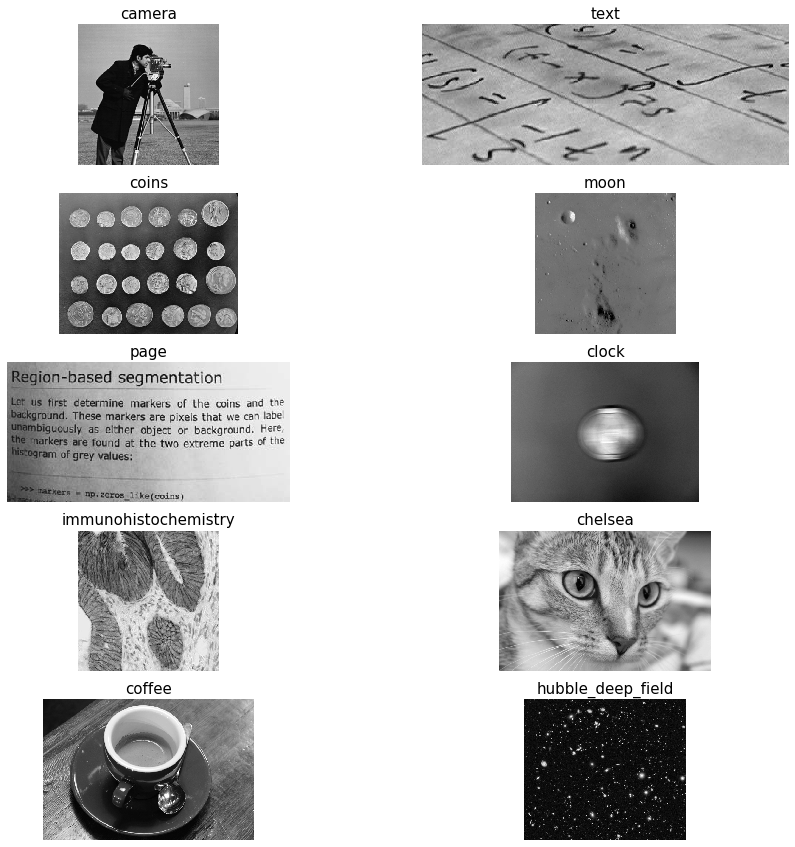

In [8]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(images[i],cmap='gray')
    plt.title(imgs_to_use[i],fontsize=15)
    plt.axis('off')

We'll extract 62x47 thumbnails from these 10 images

In [9]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img,N,scale=1.0,patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale*np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,max_patches=N,random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale !=1:
        patches = np.array([transform.resize(patch,patch_size) for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im,500,scale) for im in images for scale in [1.0, 2.0]])

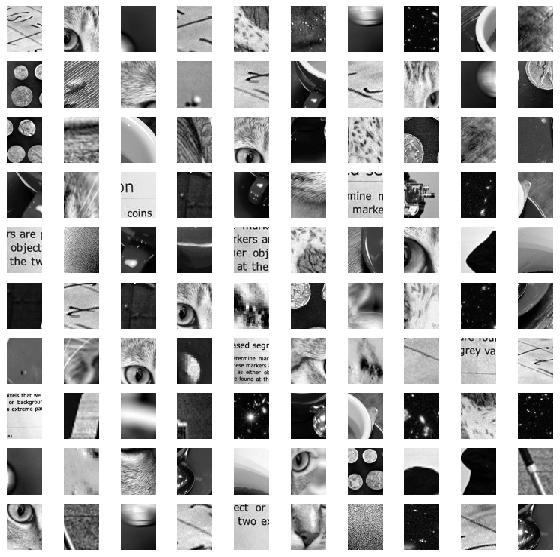

In [10]:
'display 100 (randomly chosen) nonface images'
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(negative_patches[np.random.randint(10000)],cmap='gray')
    plt.axis('off')

In [ ]:
negative_patches.shape

This gives us a sample of 10,000 nonface images

## Combine sets and extract HOG features

In [ ]:
hog_positive_patches = np.array([feature.hog(img) for img in positive_patches])
hog_negative_patches = np.array([feature.hog(img) for img in negative_patches])

'feature matrix'
X = np.r_[hog_positive_patches, hog_negative_patches]

'label vector'
y = np.zeros(X.shape[0]) # 1 = face; 0 = nonface
y[:positive_patches.shape[0]]=1

In [ ]:
y.shape

## Assignment:

Using X and y, train a logistic regression model

In [ ]:
# your logistic regression classifier here
log_clf = 

In [ ]:
# train the classifier

## Find faces in a new image

Now that we have a logistic regression model in place, let's grab a new image and see how the model does.

(-0.5, 367.5, 183.5, -0.5)

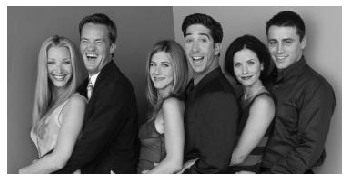

In [3]:
import matplotlib.image as mpimg 
from skimage import io

url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Classification/Homework/Images/friends.jpg'
new_image = io.imread(url)

new_image = color.rgb2gray(new_image) #transform image into gray scale
plt.imshow(new_image,cmap='gray')
plt.axis('off')

We will pass a sliding window across the image, using the classifier function to evaluate whether that window contains a face or not.

In [ ]:
def sliding_window(img,patch_size=positive_patches[0].shape,
                  istep=2,jstep=2,scale=1.0):
    Ni,Nj = (int(scale*s) for s in patch_size)
    for i in range(0,img.shape[0]-Ni,istep):
        for j in range(0,img.shape[1]-Ni,jstep):
            patch = img[i:i+Ni,j:j+Nj]
            if scale !=1:
                patch - transform.resize(patch,patch_size)
            yield(i,j), patch
            
indices, patches = zip(*sliding_window(new_image)) #apply sliding_window to new_image
patches_hog = np.array([feature.hog(patch) for patch in patches]) #extract HOG features

Finally, we can take the HOG features patches and use the classifier function to evaluate whether each patch contains a face

In [ ]:
labels = log_clf.predict(patches_hog)

In [ ]:
'draw a red rectangle where the classifier function has found a face'
fig, ax = plt.subplots()
ax.imshow(new_image,cmap='gray')
ax.axis('off')

Ni,Nj = positive_patches[0].shape
indices = np.array(indices)
for i,j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j,i), Nj,Ni,edgecolor='red',alpha=0.3,lw=2,facecolor='none'))

All of the detected patches found a face in the image!